In [65]:
import pandas as pd
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore

import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing

In [66]:
# 서연 data
data = pd.read_excel("C:/Users/PC/Desktop/KUBIG/KDI/data/oda2.xlsx")

In [67]:
# 원준 data
data = pd.read_csv("C:/Users/PC/Desktop/KUBIG/KDI/data/new_data.csv")

oda_gni = data[(data['TIME'] == 2022) & (data['MEASURE'] == 'PC_GNI')][['LOCATION', 'Value']].rename({'Value':'ODA/GNI'}, axis=1)
net_oda = data[(data['TIME'] == 2022) & (data['MEASURE'] == 'MLN_USD') & (data['SUBJECT'] == 'ODAGRANT')][['LOCATION', 'Value']].rename({'Value':'Net_ODA'}, axis=1)

data = pd.merge(oda_gni, net_oda, how = 'left', on = 'LOCATION')

In [68]:
data = data[data['LOCATION'] != 'DAC']
# data = data[data['LOCATION'] != 'DEU']
# data = data[data['LOCATION'] != 'USA']

In [69]:
# scaler = RobustScaler()

# ODA/GNI와 Net_ODA 열에 로버스트 스케일링 적용
scaler = RobustScaler()
data[['ODA/GNI', 'Net_ODA']] = scaler.fit_transform(data[['ODA/GNI', 'Net_ODA']])

# z-score scaling
# data[['ODA/GNI', 'Net_ODA']] = data[['ODA/GNI', 'Net_ODA']].apply(zscore)

# Min-Max Scaling 적용 (범위: [0, 1])
# scaler = MinMaxScaler()
# data[['ODA/GNI', 'Net_ODA']] = scaler.fit_transform(data[['ODA/GNI', 'Net_ODA']])

# Clustering

In [70]:
method = 'complete'
cluster_k = 3

In [71]:
def clustering_vis(clt, *highlight_locations):
    cluster_colors = ['#901c2d', '#ac7254', '#e2c799']
    # Set up the plot
    plt.figure(figsize=(8, 4))

    # Flag to track whether the legend for highlighted locations has been added
    highlight_legend_added = False

    # Scatter plot for each cluster
    sns.scatterplot(data=clt, x='ODA/GNI', y='Net_ODA', hue='cluster', palette=cluster_colors, s=50)

    # Scatter plot for each highlighted location
    for highlight_location in highlight_locations:
        highlight_point = clt[clt['LOCATION'] == highlight_location]

        if not highlight_point.empty:
            if not highlight_legend_added:
                # Scatter plot for the highlighted location with a single legend entry
                plt.scatter(highlight_point['ODA/GNI'], highlight_point['Net_ODA'],
                            color='blue', s=50, label='Highlight', alpha=0.2)
                highlight_legend_added = True
            else:
                # Scatter plot for the highlighted location without adding to the legend
                plt.scatter(highlight_point['ODA/GNI'], highlight_point['Net_ODA'],
                            color='blue', s=50, alpha=0.3)

            # Text annotation for the highlighted location
            plt.annotate(highlight_location,
                         (highlight_point['ODA/GNI'].values[0], highlight_point['Net_ODA'].values[0]),
                         fontsize=10, color='#eb3a54', ha='right', weight='bold')

    # Plot settings
    plt.title(f'Hierarchical Clustering - {method.capitalize()} Link', color = '#ab5b4c', fontweight='bold')
    plt.xlabel('ODA/GNI', color = '#ab5b4c', fontweight='bold')
    plt.ylabel('Net ODA', color = '#ab5b4c', fontweight='bold')
    plt.tick_params(axis='both', colors='#ab5b4c')
    # Display custom legend
    plt.legend()
    plt.show()

# Elbow Method

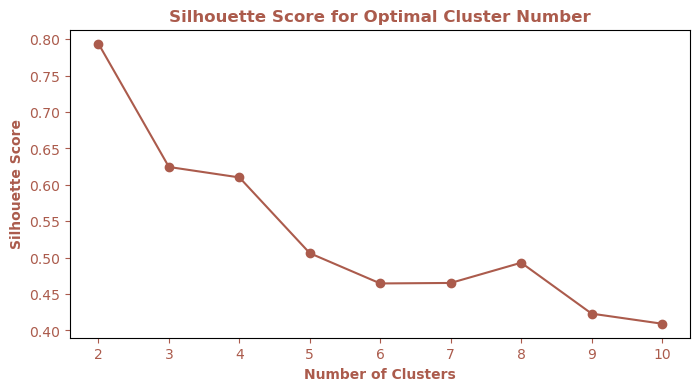

In [72]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.metrics import silhouette_score

X = data[['ODA/GNI', 'Net_ODA']]

silhouette_scores = []

for k in range(2, 11):
    # linkage matrix 계산
    linkage_matrix = linkage(X, method=method)
    
    # 클러스터 할당
    clusters = fcluster(linkage_matrix, k, criterion='maxclust')
    
    # Silhouette Score 계산
    silhouette_avg = silhouette_score(X, clusters)
    silhouette_scores.append(silhouette_avg)

# Silhouette Score 그래프
plt.figure(figsize=(8, 4))
plt.plot(range(2, 11), silhouette_scores, marker='o', color = '#ab5b4c')
plt.title('Silhouette Score for Optimal Cluster Number', color = '#ab5b4c', fontweight='bold')
plt.xlabel('Number of Clusters', color = '#ab5b4c', fontweight='bold')
plt.ylabel('Silhouette Score', color = '#ab5b4c', fontweight='bold')
plt.tick_params(axis='both', colors='#ab5b4c')
plt.show()

# Clustering

Text(0, 0.5, 'Distance')

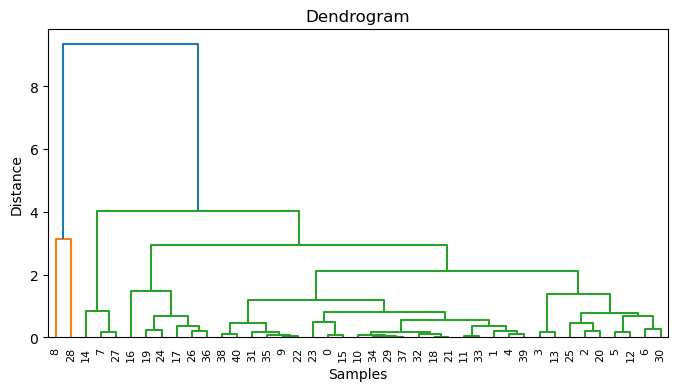

In [73]:
import numpy as np

X = data[['ODA/GNI', 'Net_ODA']]

# linkage matrix 계산
linkage_matrix = linkage(X, method=method)

# 클러스터 할당
clusters = fcluster(linkage_matrix, cluster_k, criterion='maxclust')

# 클러스터 레이블을 데이터프레임에 할당
data['cluster'] = clusters

# Dendrogram 그리기
plt.figure(figsize=(8, 4))
dendrogram(linkage_matrix)

plt.title('Dendrogram')
plt.xlabel('Samples')
plt.ylabel('Distance')

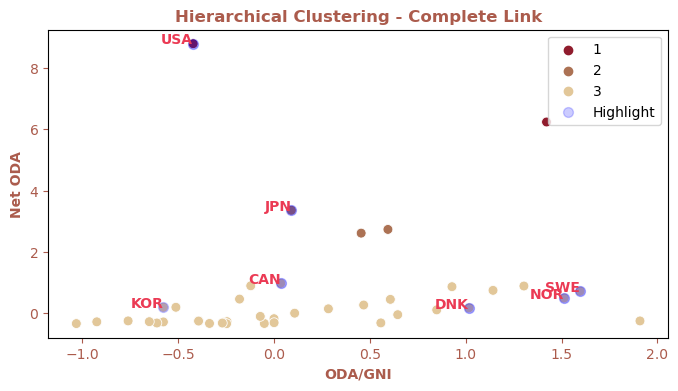

In [74]:
# 인도주의적 국가: SWE, NOR, DNK
# 상업주의적 국가: JPN, 

clustering_vis(data, 'KOR', 'SWE', 'NOR', 'DNK', 'USA', 'JPN', 'CAN')

In [75]:
for cluster_label in sorted(data['cluster'].unique()):
    cluster_locations = data[data['cluster'] == cluster_label]['LOCATION'].tolist()
    print(f"Cluster {cluster_label} Locations: {', '.join(cluster_locations)}")

Cluster 1 Locations: DEU, USA
Cluster 2 Locations: FRA, JPN, GBR
Cluster 3 Locations: AUS, AUT, BEL, CAN, CZE, DNK, FIN, GRC, HUN, ISL, IRL, ITA, KOR, LUX, NLD, NZL, NOR, POL, PRT, SVK, ESP, SWE, CHE, TUR, BGR, EST, ISR, LVA, LTU, MLT, ROU, SAU, SVN, TWN, ARE, THA
